In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Quick data visualization

First let's see how our images look like:

📂 Classes détectées : ['Lung_Opacity', 'Normal', 'COVID', 'Viral Pneumonia', 'train', 'test']
⚠ Pas de dossier 'images' trouvé pour train
⚠ Pas de dossier 'images' trouvé pour test


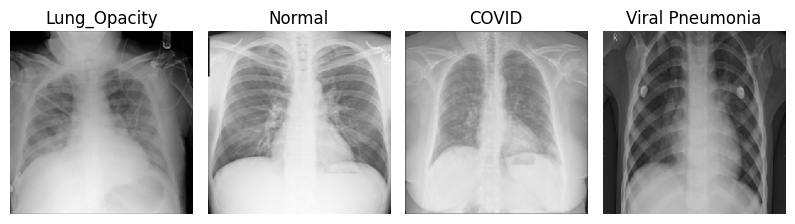

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img


base_path = "/content/drive/My Drive/COVID-19_Radiography_Dataset"


classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]


if not classes:
    print("❌ Aucun sous-dossier trouvé, vérifiez le dataset.")
else:
    print(f"📂 Classes détectées : {classes}")

    plt.figure(figsize=(12, 6))
    images_found = 0


    for i, class_name in enumerate(classes):
        images_path = os.path.join(base_path, class_name, "images")
        if not os.path.exists(images_path):
            print(f"⚠ Pas de dossier 'images' trouvé pour {class_name}")
            continue


        image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            img_path = os.path.join(images_path, image_files[0])
            img = load_img(img_path, target_size=(224, 224))

            plt.subplot(1, len(classes), images_found + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

            images_found += 1

    if images_found > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image trouvée dans les classes.")


In [ ]:

for expression in os.listdir(base_path + "/train"):
    print(str(len(os.listdir(base_path+ "/train/" + expression))) + " " + expression + " images")

9782 Normal images
6014 Lung_Opacity images
3480 COVID images
1293 Viral Pneumonia images


In [ ]:

import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = "/content/drive/My Drive/COVID-19_Radiography_Dataset/train"


classes = os.listdir(train_dir)
data = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = [
        os.path.join(class_name, img)
        for img in os.listdir(class_path)
        if img.endswith(('png', 'jpg', 'jpeg'))
    ]
    data.extend([(img, class_name) for img in images])


df = pd.DataFrame(data, columns=["filename", "class"])


min_samples = df['class'].value_counts().min()
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


pic_size = 224
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    df_balanced,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(pic_size, pic_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


print("📊 Nouvelle distribution des classes :\n", df_balanced['class'].value_counts())


<ipython-input-4-f8dabb8af68f>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


Found 5172 validated image filenames belonging to 4 classes.
📊 Nouvelle distribution des classes :
 class
COVID              1293
Lung_Opacity       1293
Normal             1293
Viral Pneumonia    1293
Name: count, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2



local_weights_path = 'imagenet'
IMG_SHAPE = (224, 224, 3)


baseModel = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights=local_weights_path)

print("Number of layers in the base model: ", len(baseModel.layers))



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  154


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

def create_model():
    for layer in baseModel.layers[:150]:
        layer.trainable = False
    for layer in baseModel.layers[150:]:
        layer.trainable = True

    model = Sequential([
        baseModel,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])


    # Compilation
    model.compile(optimizer=Adam(learning_rate=3e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3,
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
model=create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,468 (9.27 MB)

 Trainable params: 585,284 (2.23 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

Fold 1/5


<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4084 validated image filenames belonging to 4 classes.
Found 948 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1306s 10s/step - accuracy: 0.3368 - loss: 1.5696 - val_accuracy: 0.5612 - val_loss: 1.0416
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.5095 - loss: 1.1145 - val_accuracy: 0.6371 - val_loss: 0.8947
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.5904 - loss: 0.9783 - val_accuracy: 0.6920 - val_loss: 0.7942
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.6513 - loss: 0.8648 - val_accuracy: 0.7300 - val_loss: 0.7288
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.6723 - loss: 0.7820 - val_accuracy: 0.7658 - val_loss: 0.6384
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.7138 - loss: 0.7262 - val_accuracy: 0.7827 - val_loss: 0.5867
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.7497 - loss: 0.6638 - val_accuracy: 0.7922 - val_loss: 0.5501
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.7641 - loss: 0

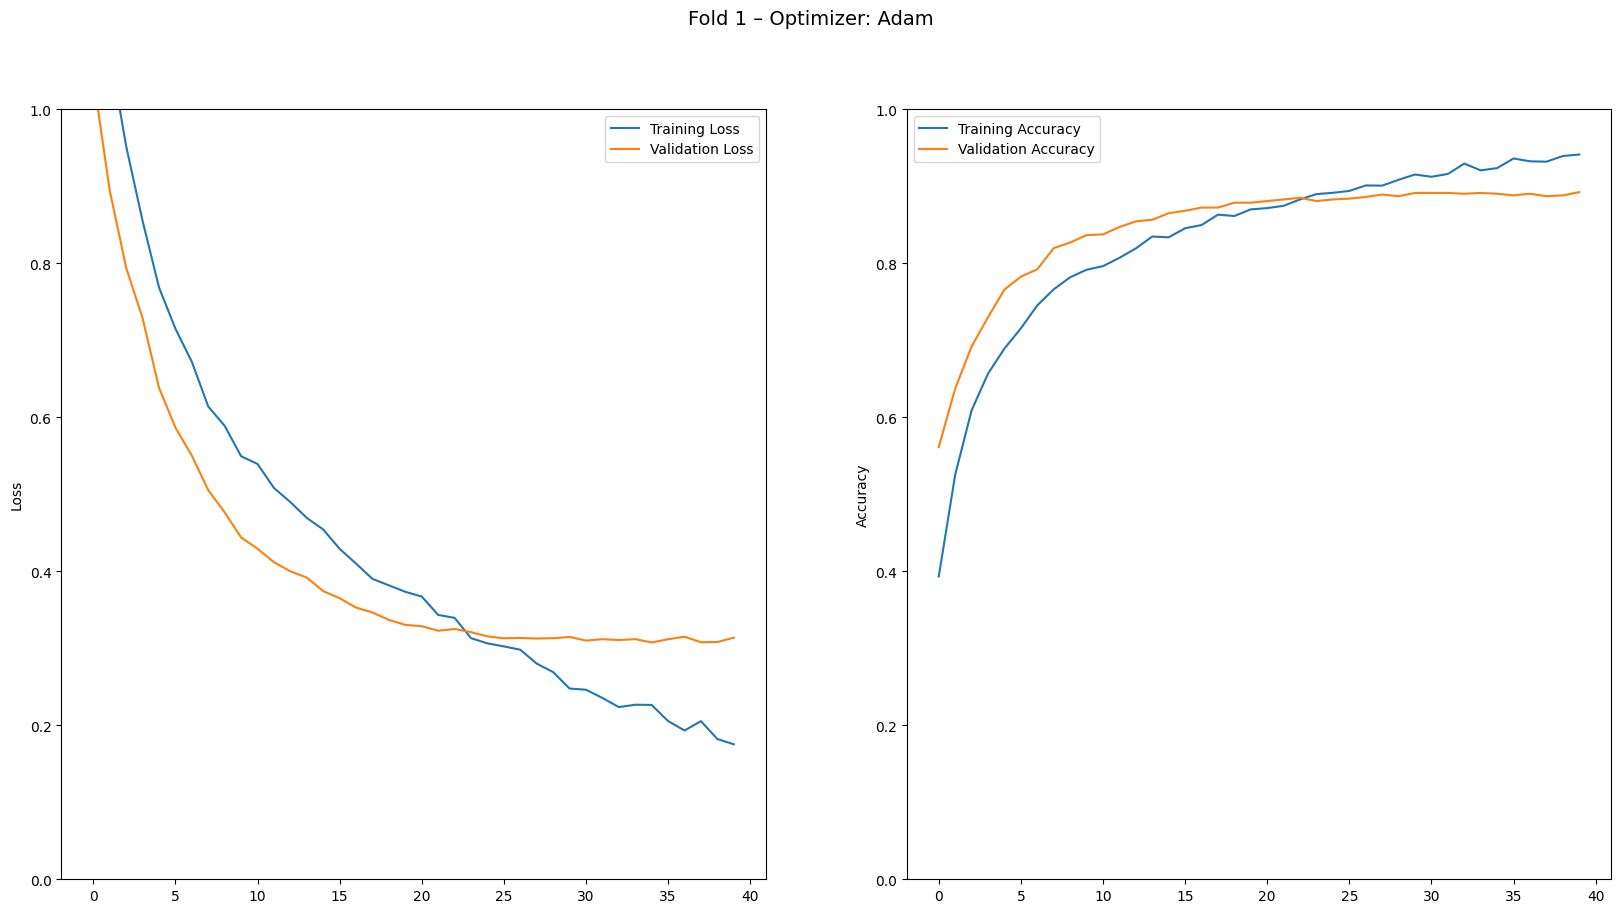

Fold 2/5


<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4064 validated image filenames belonging to 4 classes.
Found 968 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 80s 551ms/step - accuracy: 0.3355 - loss: 1.5041 - val_accuracy: 0.7469 - val_loss: 0.8505
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.6121 - loss: 0.9523 - val_accuracy: 0.8037 - val_loss: 0.6445
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.6779 - loss: 0.8166 - val_accuracy: 0.8192 - val_loss: 0.5449
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.6958 - loss: 0.7777 - val_accuracy: 0.8440 - val_loss: 0.4898
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.7434 - loss: 0.6826 - val_accuracy: 0.8512 - val_loss: 0.4499
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.7605 - loss: 0.6306 - val_accuracy: 0.8636 - val_loss: 0.4122
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.7955 - loss: 0.5618 - val_accuracy: 0.8688 - val_loss: 0.3890
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.8106 - loss: 0

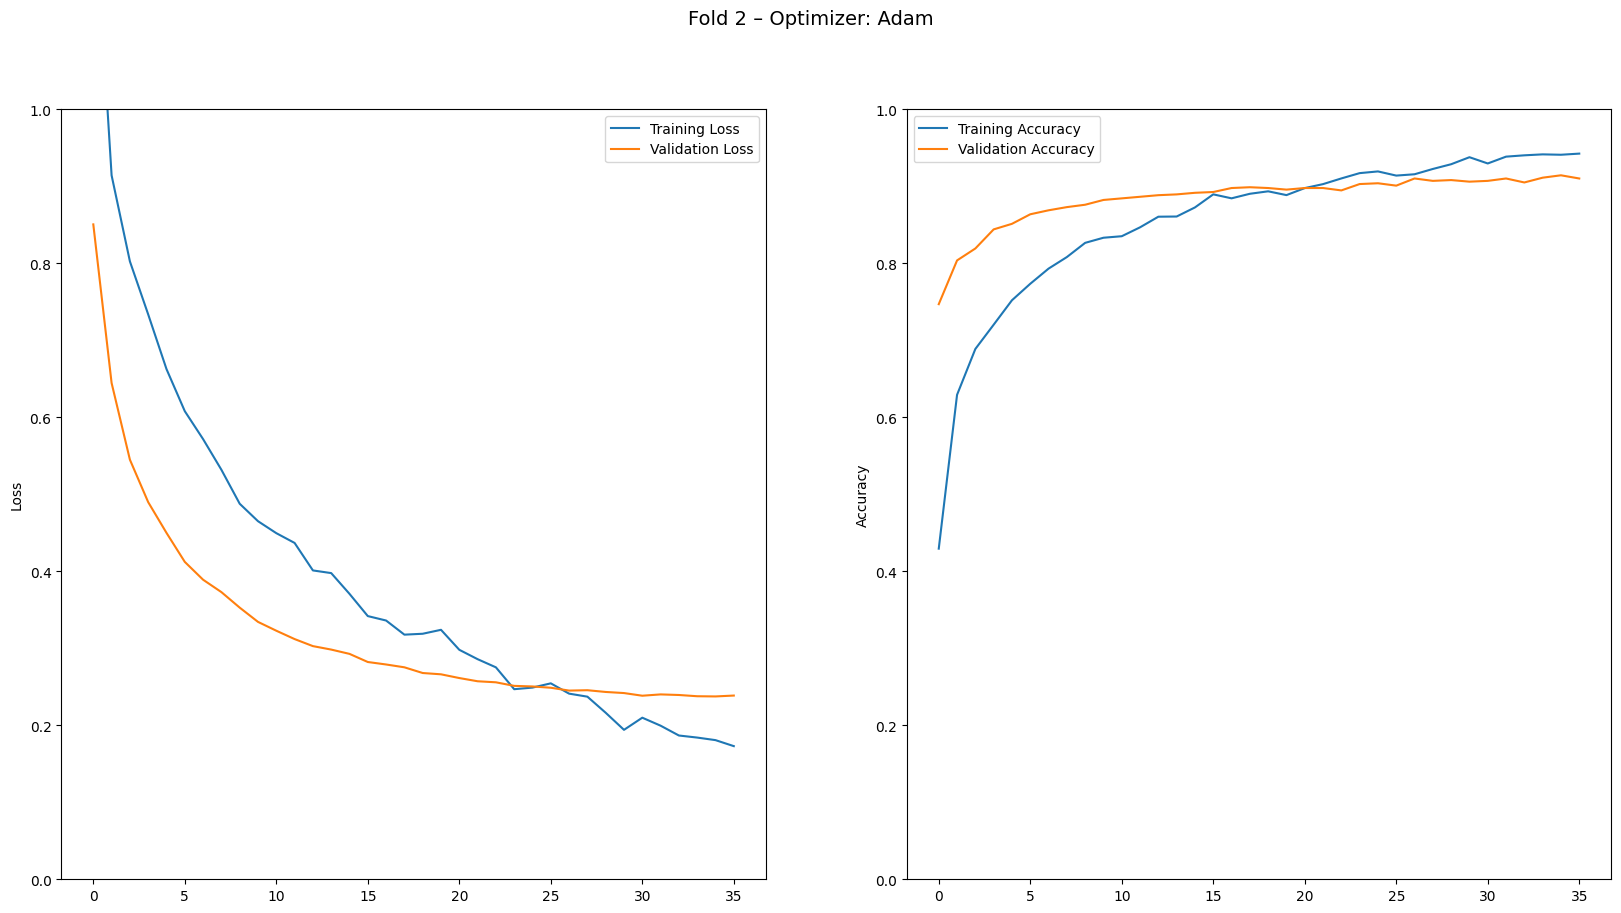

Fold 3/5


<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4096 validated image filenames belonging to 4 classes.
Found 956 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - accuracy: 0.2990 - loss: 1.6762 - val_accuracy: 0.7552 - val_loss: 0.8585
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.5592 - loss: 1.0414 - val_accuracy: 0.8243 - val_loss: 0.5903
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 0.6595 - loss: 0.8375 - val_accuracy: 0.8536 - val_loss: 0.4749
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.7162 - loss: 0.7150 - val_accuracy: 0.8692 - val_loss: 0.4020
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 265ms/step - accuracy: 0.7440 - loss: 0.6425 - val_accuracy: 0.8849 - val_loss: 0.3521
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.7881 - loss: 0.5800 - val_accuracy: 0.8923 - val_loss: 0.3199
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.7857 - loss: 0.5599 - val_accuracy: 0.8985 - val_loss: 0.2994
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.8184 - loss: 0

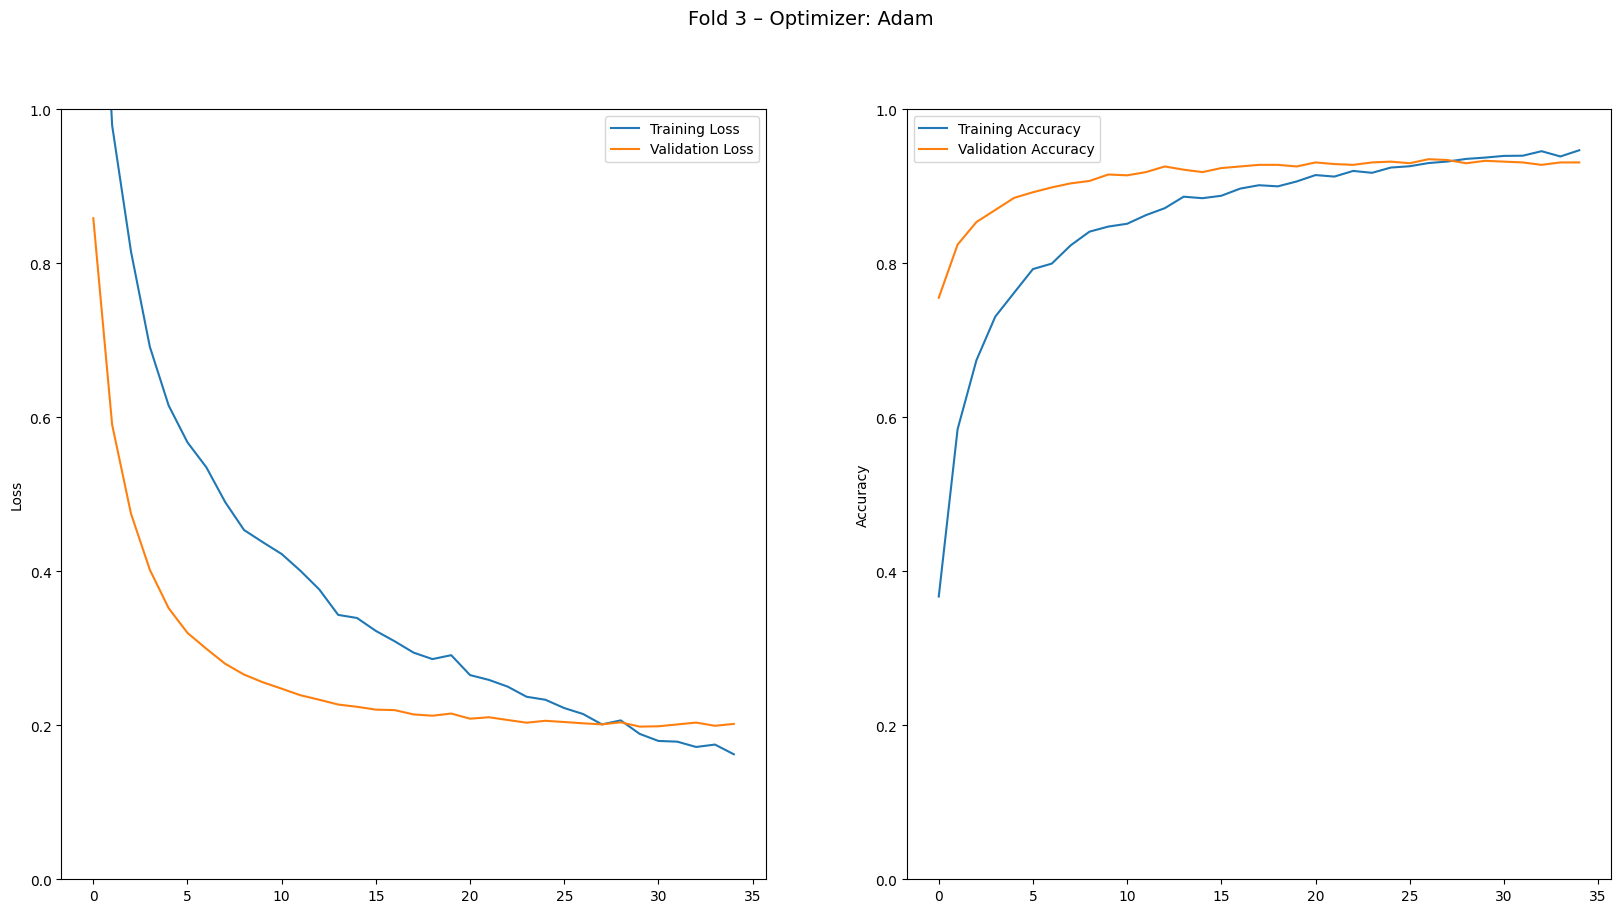

Fold 4/5


<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4104 validated image filenames belonging to 4 classes.
Found 984 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 47s 292ms/step - accuracy: 0.3673 - loss: 1.5049 - val_accuracy: 0.7907 - val_loss: 0.7141
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.5910 - loss: 0.9542 - val_accuracy: 0.8608 - val_loss: 0.5199
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.6753 - loss: 0.7810 - val_accuracy: 0.8872 - val_loss: 0.4171
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - accuracy: 0.7280 - loss: 0.6992 - val_accuracy: 0.9065 - val_loss: 0.3552
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.7592 - loss: 0.6140 - val_accuracy: 0.9096 - val_loss: 0.3152
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.7919 - loss: 0.5628 - val_accuracy: 0.9157 - val_loss: 0.2829
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.8052 - loss: 0.5205 - val_accuracy: 0.9187 - val_loss: 0.2625
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - accuracy: 0.8150 - loss: 0

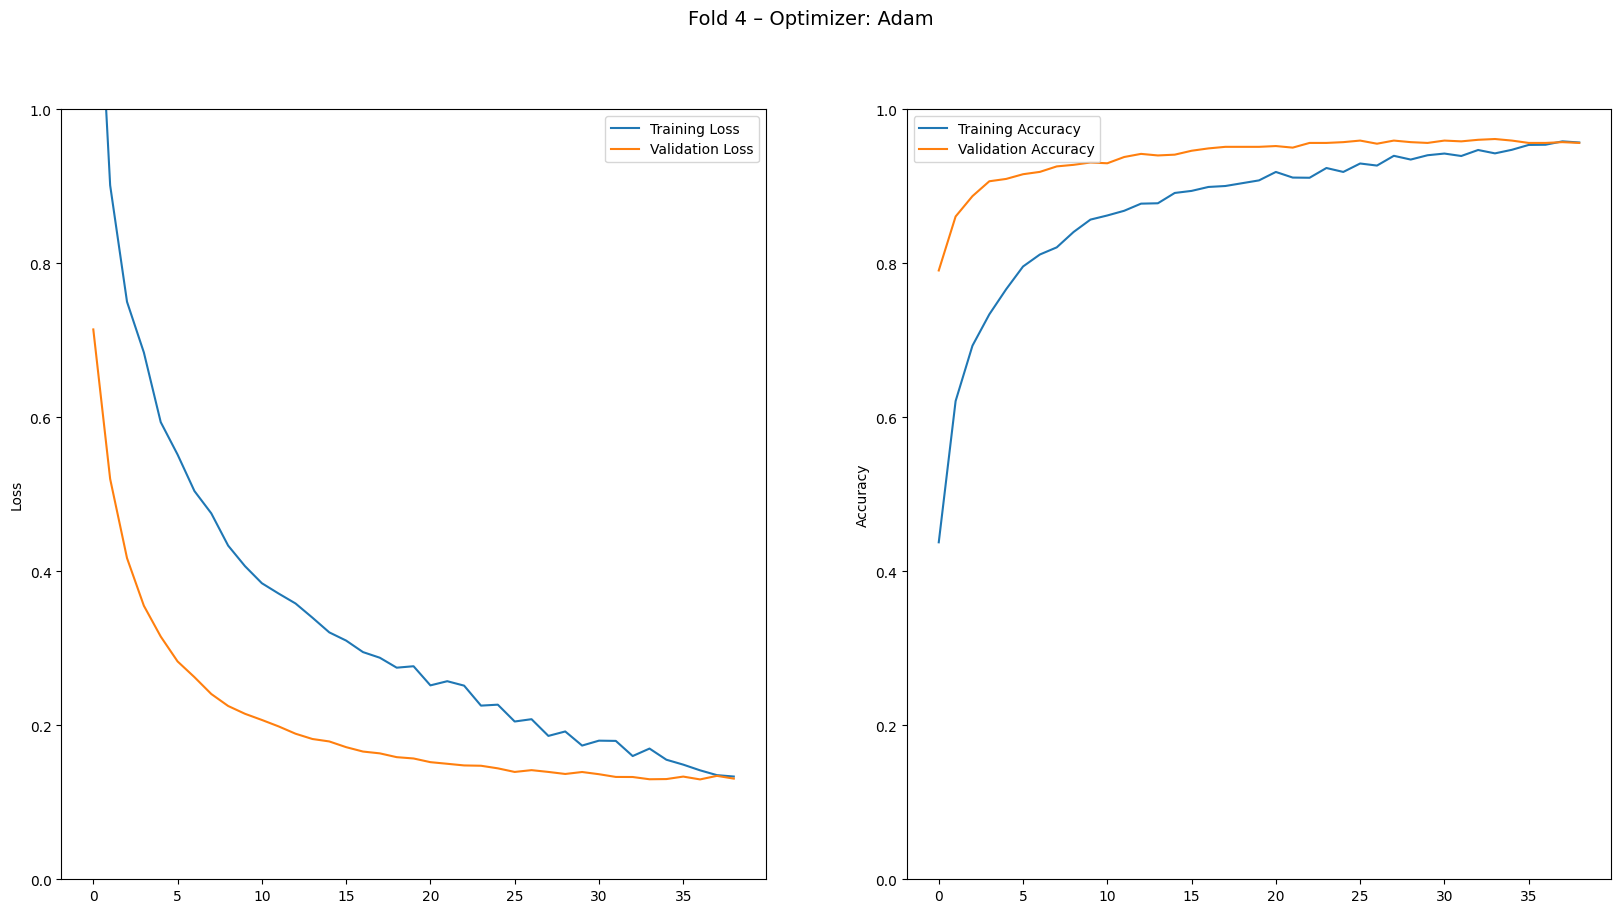

Fold 5/5


<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-9-e554d0f4c6bf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4040 validated image filenames belonging to 4 classes.
Found 956 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 46s 283ms/step - accuracy: 0.3702 - loss: 1.4921 - val_accuracy: 0.8211 - val_loss: 0.6748
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step - accuracy: 0.5917 - loss: 0.9497 - val_accuracy: 0.8619 - val_loss: 0.4768
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.7165 - loss: 0.7375 - val_accuracy: 0.8818 - val_loss: 0.3878
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.7541 - loss: 0.6279 - val_accuracy: 0.8923 - val_loss: 0.3304
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.7950 - loss: 0.5537 - val_accuracy: 0.9048 - val_loss: 0.2929
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.8012 - loss: 0.5234 - val_accuracy: 0.9027 - val_loss: 0.2685
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.8360 - loss: 0.4504 - val_accuracy: 0.9195 - val_loss: 0.2519
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.8503 - loss: 0

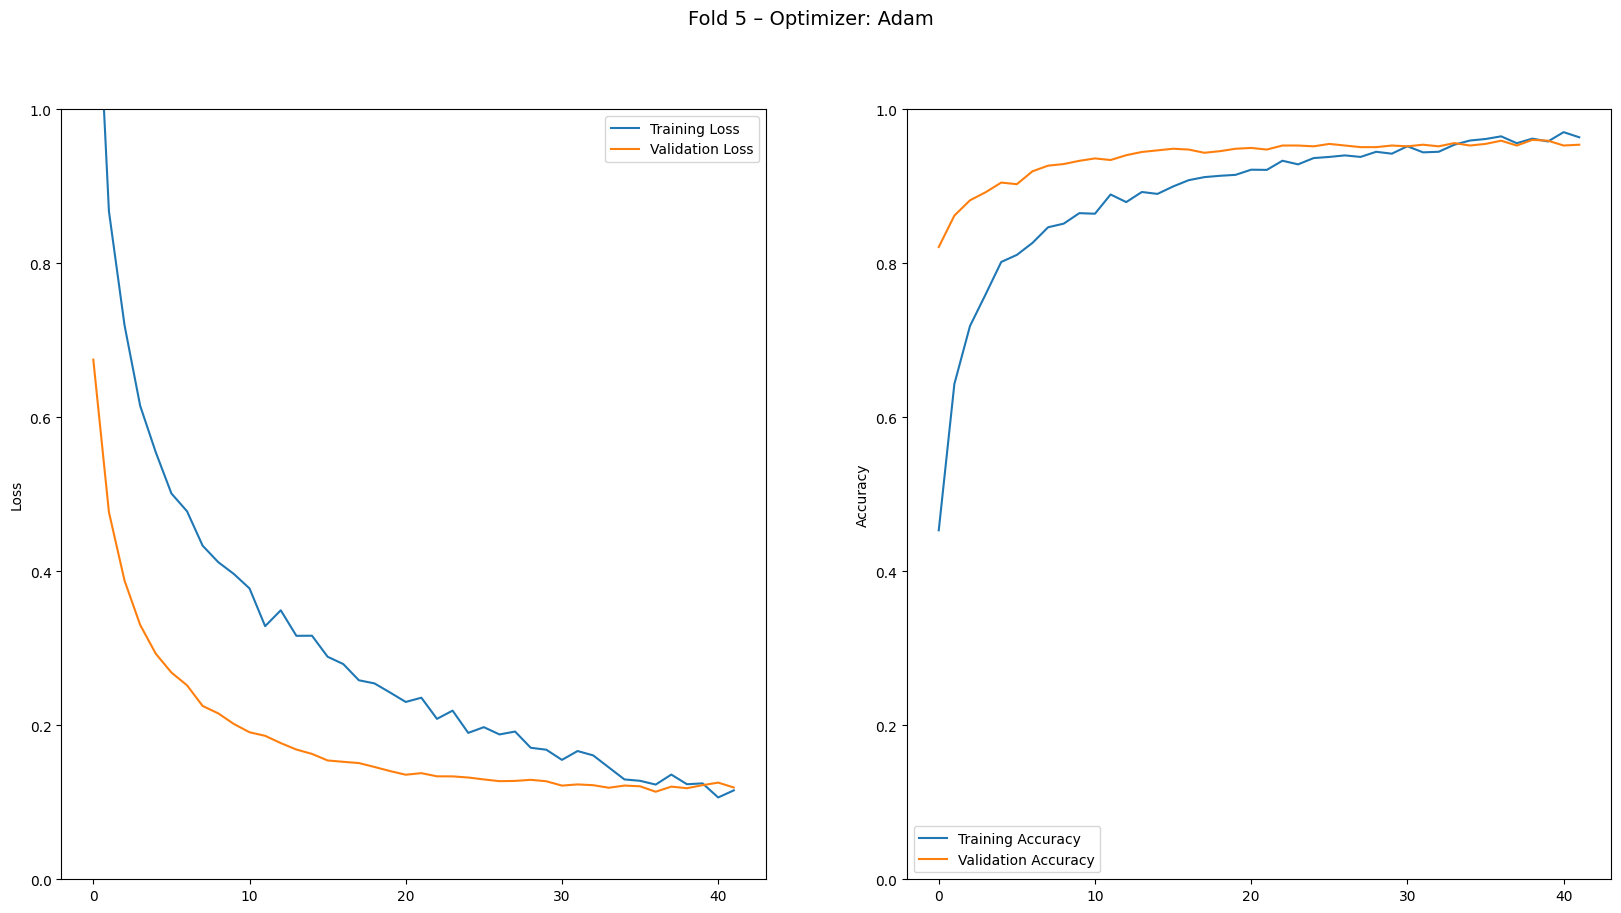


🎯 Moyenne des accuracies sur 5 folds : 0.9327


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (224, 224, 3)
batch_size = 32
epochs = 50
k_folds = 5
num_classes = 4


kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)
fold_accuracies = []

image_dir = "/content/drive/My Drive/COVID-19_Radiography_Dataset/train"

kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)

for fold, (train_idx, val_idx) in enumerate(kf.split(df_balanced)):
    print(f'Fold {fold+1}/{k_folds}')

    train_df = df_balanced.iloc[train_idx]
    val_df = df_balanced.iloc[val_idx]



    train_generator = datagen.flow_from_dataframe(
        train_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )

    model = create_model()

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")

    # Courbes
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    plt.suptitle(f'Fold {fold+1} – Optimizer: Adam', fontsize=14)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.show()

import numpy as np

print(f'\n🎯 Moyenne des accuracies sur {k_folds} folds : {np.mean(fold_accuracies):.4f}')


In [ ]:
model.save('/content/drive/My Drive/covid_MobileNet.hdf5')
print("SAVED")

SAVED


# Analyze the results

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model



test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/COVID-19_Radiography_Dataset/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='categorical',
    shuffle=False
)

Found 8402 images belonging to 4 classes.


✅ Accuracy: 89.47%


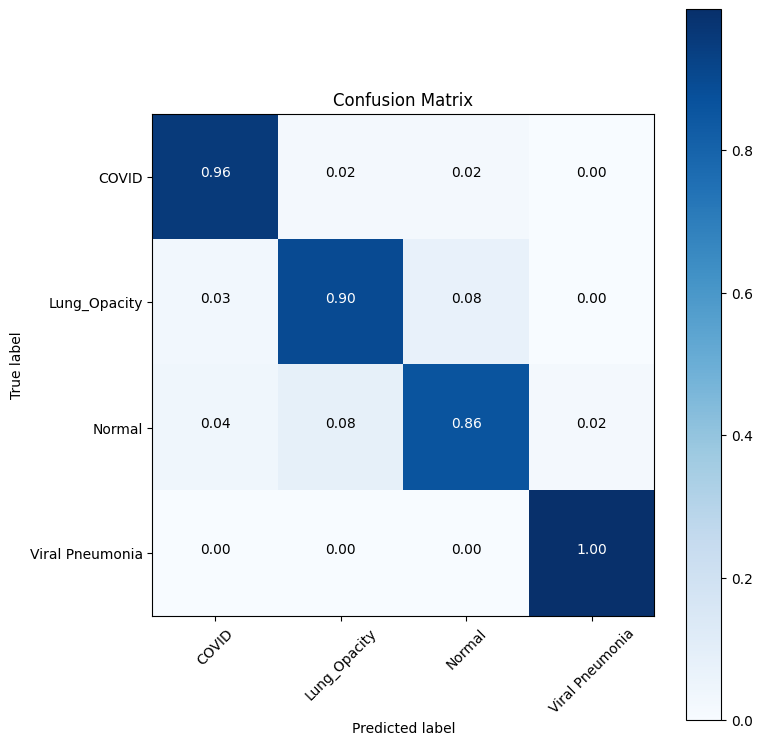

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Affiche la matrice de confusion normalisée"""
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


y_pred = []
y_true = []
for i in range(len(test_generator)):
    X_test_batch, y_test_batch = test_generator[i]
    predictions_batch = model.predict(X_test_batch, verbose=0)
    y_pred_batch = np.argmax(predictions_batch, axis=1)
    y_true_batch = np.argmax(y_test_batch, axis=1)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_true_batch)


y_pred = np.array(y_pred)
y_true = np.array(y_true)


cnf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

class_names = list(train_generator.class_indices.keys())


print(f"✅ Accuracy: {accuracy * 100:.2f}%")
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')